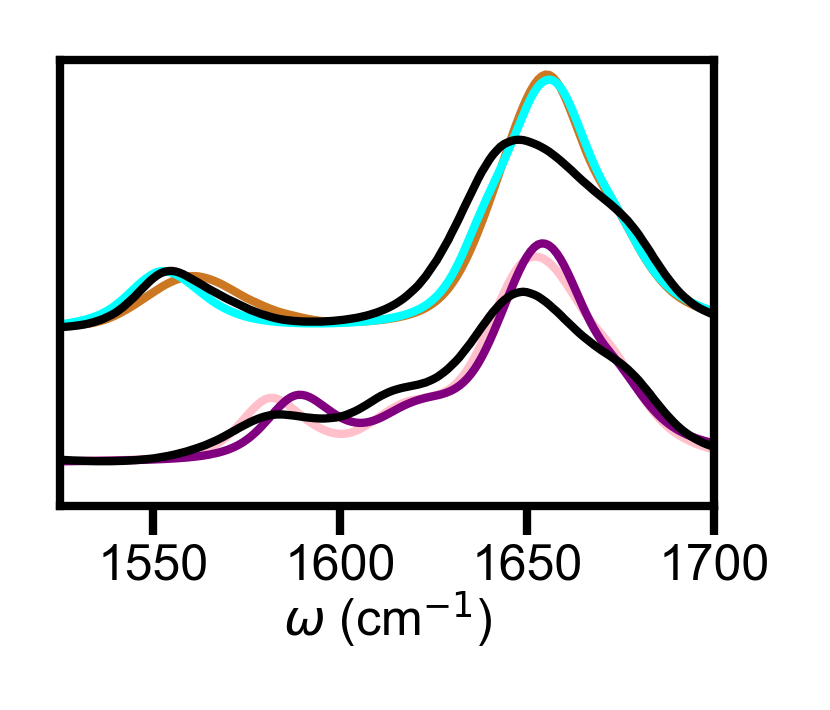

In [1]:
### BOTTOM CENTER FIGURE FOR TABLE OF CONTENTS ###
### 4 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
WAVENUMBERS_FILE = BASE_DIR / 'waxis.txt'
EXP_DIR = BASE_DIR / 'exp_data' / 'processed_FTIRs'
SIM_DIR = BASE_DIR / 'sim_data' / 'sim_spec'
PROP_DIR = BASE_DIR / 'prop_array'

# Data Specifications
FORCE_FIELD = 'CHARMM27_TIP3P'
MAP_TYPE = 'DC1Fnew'

# Analysis Parameters
WAVENUMBER_RANGE = (1525, 1750)  # Full range for loading data
PLOT_RANGE = (1525, 1700)  # Range for plotting
PURITY_THRESHOLD = 0.95

# Plotting Specifications
FIGURE_WIDTH = 1.2
FIGURE_HEIGHT = 1.0
FONT_SIZES = {'labels': 6, 'text': 6, 'ticks': 6, 'legend': 6}
LINE_WIDTH = 1.0
GROUP_OFFSET = 0.15  # Vertical offset between the two groups (scaled spectra need more space)
NORM = 12.5  # Target area for normalization - adjust this to scale spectra visibility

# -----------------------------------------------------------------------------
# DATA LOADING FUNCTIONS
# -----------------------------------------------------------------------------

def load_wavenumber_axis():
    """Load wavenumber axis within analysis range."""
    wavenumbers = np.loadtxt(WAVENUMBERS_FILE)
    return wavenumbers[(wavenumbers >= WAVENUMBER_RANGE[0]) & 
                       (wavenumbers <= WAVENUMBER_RANGE[1])]

def load_proportions():
    """Load proportions array for force field."""
    filepath = PROP_DIR / FORCE_FIELD / f'proportions_array_0100ps_{FORCE_FIELD}_PAPER.npy'
    return np.load(filepath)

def normalize_by_area(spectrum, wavenumbers):
    """Normalize spectrum to have a specific integrated area."""
    area = np.trapz(spectrum, x=wavenumbers)
    return spectrum / area * NORM

def load_experimental(file_name, wavenumbers):
    """Load and normalize experimental spectrum."""
    filepath = EXP_DIR / f'GVGn1_{file_name}_50mgmL_phos_150mM_pH1_basecorr_processed.npy'
    spectrum = np.load(filepath)
    return normalize_by_area(spectrum, wavenumbers)

def load_simulated(name, wavenumbers):
    """Load and normalize simulated spectra."""
    filepath = SIM_DIR / FORCE_FIELD / f'{MAP_TYPE}_{FORCE_FIELD}_{name}_ftir.npy'
    raw_spectra = np.load(filepath)
    corrected = raw_spectra - np.min(raw_spectra, axis=1)[:, None]
    return np.array([normalize_by_area(spectrum, wavenumbers) for spectrum in corrected])

def compute_state_averages(simulated, proportions, wavenumbers):
    """Compute average spectra for pure states."""
    averages = []
    
    for idx in range(4):  # C, E, NC, N
        mask = proportions[:, idx] > PURITY_THRESHOLD
        
        if np.any(mask):
            avg = normalize_by_area(np.mean(simulated[mask], axis=0), wavenumbers)
        else:
            avg = np.zeros_like(wavenumbers)
        
        averages.append(avg)
    
    return averages

# -----------------------------------------------------------------------------
# PLOTTING FUNCTION
# -----------------------------------------------------------------------------

def plot_overlaid_spectra(ax, wavenumbers, experimental, C, E, NC, N, label, feature_type, base_offset):
    """
    Plot spectral comparison with all three spectra overlaid at the same baseline.
    """
    # Spectra are already normalized to NORM area, no additional scaling needed
    
    if feature_type == 'N-bend':
        # Average states WITHOUT N-bend (C+E) vs WITH N-bend (NC+N)
        avg1 = (C + E) / 2
        avg2 = (NC + N) / 2
        label1, color1 = 'C + E', '#FFC0CB'  # VMD Pink
        label2, color2 = 'NC + N', '#800080'  # VMD Purple
    else:  # C-turn
        # Average states WITHOUT C-turn (E+N) vs WITH C-turn (C+NC)
        avg1 = (C + NC) / 2
        avg2 = (E + N) / 2
        label1, color1 = 'C + NC', '#CC7722'  # VMD Ochre
        label2, color2 = 'E + N', '#00FFFF'  # VMD Cyan
    
    # Plot all three spectra at the same baseline
    ax.plot(wavenumbers, avg1 + base_offset, color=color1, lw=LINE_WIDTH)
    ax.plot(wavenumbers, avg2 + base_offset, color=color2, lw=LINE_WIDTH)
    ax.plot(wavenumbers, experimental + base_offset, color='black', lw=LINE_WIDTH)

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Generate waterfall plot for G5+ and V1 (labeled as G3 and V4)."""
    
    # Set plot style
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': FONT_SIZES['labels'],
        'axes.labelsize': FONT_SIZES['labels'],
        'axes.titlesize': FONT_SIZES['labels'],
        'xtick.labelsize': FONT_SIZES['ticks'],
        'ytick.labelsize': FONT_SIZES['ticks'],
        'legend.fontsize': FONT_SIZES['legend'],
        'figure.titlesize': FONT_SIZES['labels'],
        'axes.linewidth': 1,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
    })
    
    # Load common data
    wavenumbers = load_wavenumber_axis()
    proportions = load_proportions()
    
    # Create single figure
    fig, ax = plt.subplots(1, 1, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT), dpi=600)
    
    # Process G5+ (shown as G3) - N-bend analysis (bottom group)
    try:
        experimental_g5plus = load_experimental('G5dag', wavenumbers)
        simulated_g5plus = load_simulated('G5+', wavenumbers)
        C_g5plus, E_g5plus, NC_g5plus, N_g5plus = compute_state_averages(simulated_g5plus, proportions, wavenumbers)
        
        plot_overlaid_spectra(ax, wavenumbers, experimental_g5plus, 
                            C_g5plus, E_g5plus, NC_g5plus, N_g5plus, 
                            'G3', 'N-bend', 0)
        
    except FileNotFoundError as e:
        print(f"ERROR loading G5+ data: {e}")
    
    # Process V1 (shown as V4) - C-turn analysis (top group)
    try:
        experimental_v1 = load_experimental('V1', wavenumbers)
        simulated_v1 = load_simulated('V1', wavenumbers)
        C_v1, E_v1, NC_v1, N_v1 = compute_state_averages(simulated_v1, proportions, wavenumbers)
        
        plot_overlaid_spectra(ax, wavenumbers, experimental_v1, 
                            C_v1, E_v1, NC_v1, N_v1, 
                            'V4', 'C-turn', GROUP_OFFSET)
        
    except FileNotFoundError as e:
        print(f"ERROR loading V1 data: {e}")
    
    # Format axes
    ax.set_xlim(PLOT_RANGE)
    ax.set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=FONT_SIZES['labels'], labelpad=0)
    ax.set_ylabel('')  # Remove y-axis label
    ax.set_yticks([])
    
    # Reduce tick padding to bring them closer to the plot
    ax.tick_params(axis='x', pad=1)
    
    # Set y-limits to show both groups with some padding
    ax.set_ylim([-0.05, GROUP_OFFSET + 0.3])
    
    # Make all spines visible
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('black')
    
    plt.tight_layout(pad=0.1)
    plt.show()

if __name__ == "__main__":
    main()